# Ikeda $B_e$ assumtion.

In [1]:
from rolldecayestimators import equations

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
The quadratic or cubic model can be expressed using the linearized equivalent damping ($B_e$) according to <cite data-cite="7505983/EYEMHSYH">.:

In [2]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

In [3]:
equations.B_e_equation_cubic

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi) + 0.75*B_3*omega0**2*phi_a**2)

But I have some doubt about the validity of this, which will be investigated in this notebook.

# Methodology
A quadratic and cubic model from Simplified Ikeda will be used to calculate $B_e$. $B_e$ will also be obtained from Roll-decay simulations with these models, will the value be the same?

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [4]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


In [16]:
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import rolldecayestimators

In [6]:
df_ikeda = database.load(rolldecay_table_name='rolldecay_simplified_ikeda_unlimited', limit_score=0.95, 
                             exclude_table_name='rolldecay_exclude')

In [7]:
df_ikeda.head()

,model_number,loading_condition_id,ship_speed,B_44_1,B_F_1,B_W_1,B_E_1,B_BK_1,B_L_1,B_44_2,B_F_2,B_W_2,B_E_2,B_BK_2,B_L_2,B_3,omega0,omega0_fft,zeta,d,score,phi_start,phi_stop,mean_damping,B_1,B_2,B_e,id,project_number,series_number,run_number,test_number,ship_name,ascii_name,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,project_path,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id
run_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14848,3541-A,107,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.691760,6.336792,None,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,None,10.150949,38.090976,21.286281,14848,20136522,1,32,1,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2014-12-29,roll decay,MDL,None,None,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.190,18.38,3.8,0.847,11.50,11.50,46.97,15.5,65.32,3.36,0.7669,116472.0,0.9899,8.5,55.000,284.00,46.97,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,None,None,20000.0,1.0,None,92.13,0.43,3.0,8.3,28.0,2.320,-123.0,67.8,49.40,0.0,0.0,2.0,1.0,-142.000,None,7.7,58.0,290.0,4.0
5509,3338-B,44,0.0,5.062226,1.081253,1.638319,2.342654,0.000000,0.000000,7.404880,1.081253,1.638319,4.685307,0.000000,0.000000,None,2.450442,2.450442,0.004466,0.118153,0.985986,0.153420,-0.016432,None,2.719572,14.682270,7.404880,5509,20095421,1,18,1,3338-B,20095421-ser001-k018-100hz.asc,Kursstyrning Rolldecay 0.0 kn,N:\Gamla_Projekt\ascii_files\20095421-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2010-09-02,roll decay,MDL,None,None,Kursstyrning,20095421_STX_Polar_Supply,\\sspa.local\gbg\ProjektArkiv\2009\20095421_ST...,-2.327,9.00,2.2,0.830,6.74,6.74,22.00,8.3,30.35,NaN,0.6325,11260.0,0.9890,5.1,23.889,121.40,22.00,NaN,0.000,0.0,NaN,14.0,NaN,NaN,0.990,NaN,None,None,NaN,1.0,None,0.00,0.00,NaN,4.3,NaN,NaN,NaN,NaN,12.45,NaN,NaN,2.0,1.0,NaN,None,NaN,NaN,133.4,8.0
5510,3338-B,44,3.0,8.241247,1.081253,1.720727,1.645810,0.000000,3.793457,9.887057,1.081253,1.720727,3.291620,0.000000,3.793457,None,2.450442,2.450442,0.010830,0.084283,0.984364,0.151097,-0.002482,None,6.595437,10.473446,9.887057,5510,20095421,1,19,1,3338-B,20095421-ser001-k019-100hz.asc,Kursstyrning Rolldecay 3.0 kn,N:\Gamla_Projekt\ascii_files\20095421-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2010-09-02,roll decay,MDL,None,None,Kursstyrning,20095421_STX_Polar_Supply,\\sspa.local\gbg\ProjektArkiv\2009\20095421_ST...,-2.327,9.00,2.2,0.830,6.74,6.74,22.00,8.3,30.35,NaN,0.6325,11260.0,0.9890,5.1,23.889,121.40,22.00,NaN,0.000,0.0,NaN,14.0,NaN,NaN,0.990,NaN,None,None,NaN,1.0,None,0.00,0.00,NaN,4.3,NaN,NaN,NaN,NaN,12.45,NaN,NaN,2.0,1.0,NaN,None,NaN,NaN,133.4,8.0
3462,3250,22,0.0,9.687631,1.070726,5.466792,0.649940,2.500173,0.000000,14.004694,1.070726,5.466792,1.299880,6.167296,0.000000,None,2.689203,2.689203,0.009063,0.220252,0.996212,-0.155870,0.003981,None,5.370568,24.266868,14.004694,3462,20074604,1,15,1,3250,20074604-ser001-k015-100hz.asc,Kursstyrning Rolldecay,N:\Gamla_Projekt\ascii_files\20074604-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2008-01-17,roll decay,MDL,None,None,Kursstyrning,20074604-1,\\sspa.local\gbg\ProjektArkiv\2007\20074604,6.401,15.10,5.1,NaN,15.25,15.25,48.00,17.8,63.30,1.95,NaN,161867.0,0.9985,12.0,56.463,263.75,48.00,67.0,19.780,0.0,0.0,NaN,12.1,130.0,0.870,16.9,None,None,16730.0,1.0,None,65.90,0.45,1.0,8.3,26.0,2.708,-114.0,NaN,88.40,0.0,0.0,1.0,1.0,-131.875,None,8.4,2.0,285.0,1.0
5511,3338-B,44,1

In [8]:
row = df_ikeda.iloc[0]

db = database.get_db()
run = db.session.query(Run).get(int(row.id))
run = database.load_run(run, save_as_example=False, prefer_hdf5=True)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [9]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=2, minimum_score=0.99)
scaler = ScaleFactorTransformer(scale_factor=None)  # dummy value None for now
cutter = CutTransformer(phi_max=np.deg2rad(9), phi_min=np.deg2rad(0.25), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

In [10]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
#    ('offset_transformer',offset_transformer),
]

df = run.df.copy()

preprosessor = Pipeline(steps=steps)
preprosessor.fit(X=df[['phi']])
X = preprosessor.transform(df[['phi']])

In [11]:
data = row.copy()
scale_factor=run.model.scale_factor
rho=1000
g=9.81
data['rho']=rho
data['g']=g

data['lpp']/=scale_factor
data['TA']/=scale_factor
data['TF']/=scale_factor
data['beam']/=scale_factor
data['BKL']/=scale_factor
data['BKB']/=scale_factor
data['kg']/=scale_factor
data['Volume']/=scale_factor**3
data['gm']/=scale_factor
data['V']=data['ship_speed']*1.852/3.6/np.sqrt(scale_factor)  #[m/s]
data['KXX']/=scale_factor

estimator_ikeda_quadratic_db = IkedaQuadraticEstimator.load(data=data, X=X)

<a id='different'></a>

In [12]:
estimator_ikeda_quadratic = IkedaQuadraticEstimator(**data,
                                        verify_input=False, limit_inputs=False)
estimator_ikeda_quadratic.fit(X=X)

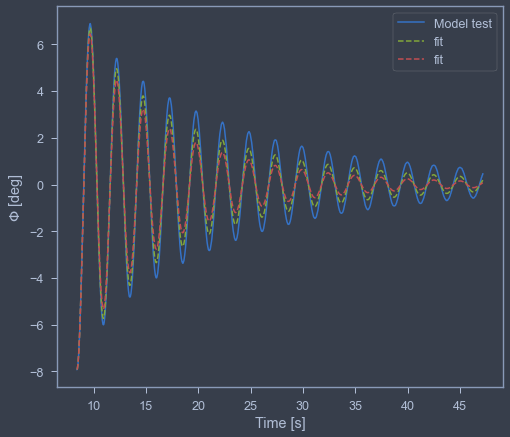

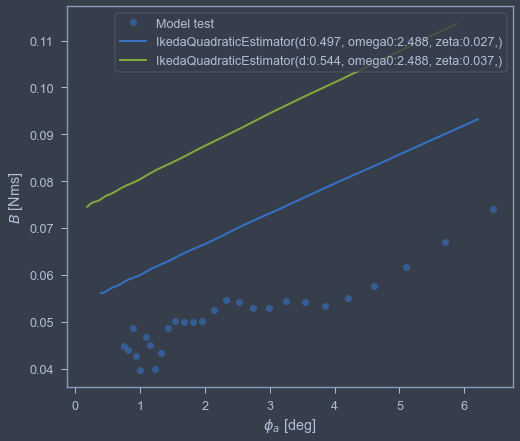

In [13]:
fig,ax=plt.subplots()
estimator_ikeda_quadratic_db.plot_fit(ax=ax)
estimator_ikeda_quadratic.plot_fit(ax=ax, model_test=False)

fig,ax=plt.subplots()
estimator_ikeda_quadratic_db.plot_damping(ax=ax)
estimator_ikeda_quadratic.plot_damping(ax=ax, include_model_test=False)

## Calculate for each $\phi_a$

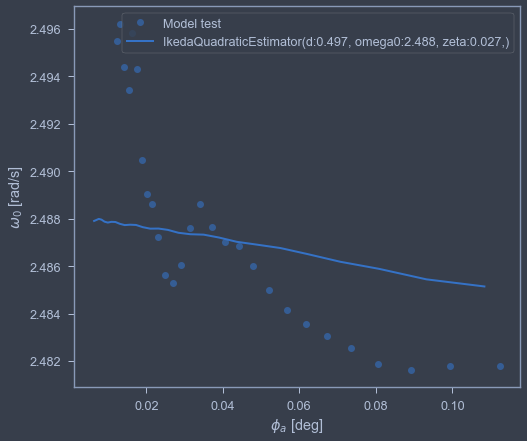

In [14]:
estimator_ikeda_quadratic_db.plot_omega0()

In [17]:
estimator_ikeda_quadratic.calculate_amplitudes_and_damping()
X_pred = estimator_ikeda_quadratic.predict(X=X)
X_amplitudes = rolldecayestimators.measure.calculate_amplitudes_and_damping(X=X_pred)

In [18]:
X_amplitudes.head()

,phi,phi1d,phi2d,phi_a,zeta_n,B_n,omega0
10.292912,0.205437,5.045877e-16,1.271821,0.102718,0.056811,0.113622,2.483525
11.557885,0.170887,7.274997e-16,1.057928,0.085443,0.053522,0.107044,2.483964
12.822412,0.143766,1.916327e-16,0.890036,0.071883,0.050915,0.101829,2.484656
14.086680,0.122084,2.853078e-16,0.755810,0.061042,0.048909,0.097818,2.485092
15.350763,0.104405,2.222614e-16,0.646357,0.052203,0.047206,0.094412,2.485439


In [19]:
data

model_number                                                       3541-A
loading_condition_id                                                  107
ship_speed                                                             13
B_44_1                                                            15.7186
B_F_1                                                             1.10144
B_W_1                                                             4.21872
B_E_1                                                            0.468786
B_BK_1                                                            3.59288
B_L_1                                                             6.33679
B_44_2                                                            21.2863
B_F_2                                                             1.10144
B_W_2                                                             4.21872
B_E_2                                                            0.937572
B_BK_2                                

In [20]:
data['draught']=(data['TA']+data['TF'])/2
data['volume']=data['Volume']

In [21]:
data2 = data.copy()

In [22]:
N = len(X_amplitudes)
data_ = np.tile(data2.values,(N,1))
inputs_raw = pd.DataFrame(data=data_, columns=data2.index)

In [23]:
for key,value in inputs_raw.items():
    try:    
        inputs_raw[key] =inputs_raw[key].astype(float)
    except:
        continue
    
    

In [24]:
inputs_raw.head()

,model_number,loading_condition_id,ship_speed,B_44_1,B_F_1,B_W_1,B_E_1,B_BK_1,B_L_1,B_44_2,B_F_2,B_W_2,B_E_2,B_BK_2,B_L_2,B_3,omega0,omega0_fft,zeta,d,score,phi_start,phi_stop,mean_damping,B_1,B_2,B_e,id,project_number,series_number,run_number,test_number,ship_name,ascii_name,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,project_path,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,rho,g,V,draught,volume
0,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,3.36,0.7669,0.700057,0.9899,8.5,55.0,5.163636,0.854,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,NaN,NaN,20000.0,1.0,NaN,1.675091,0.007818,3.0,8.3,28.0,2.32,-123.0,67.8,49.4,0.0,0.0,2.0,1.0,-142.0,NaN,7.7,58.0,290.0,4.0,1000.0,9.81,0.90178,0.209091,0.700057
1,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,3.36,0.7669,0.700057,0.9899,8.5,55.0,5.163636,0.854,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,NaN,NaN,20000.0,1.0,NaN,1.675091,0.007818,3.0,8.3,28.0,2.32,-123.0,67.8,49.4,0.0,0.0,2.0,1.0,-142.0,NaN,7.7,58.0,290.0,4.0,1000.0,9.81,0.90178,0.209091,0.700057
2,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,3.36,0.7669,0.700057,0.9899,8.5,55.0,5.163636,0.854,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,NaN,NaN,20000.0,1.0,NaN,1.675091,0.007818,3.0,8.3,28.0,2.32,-123.0,67.8,49.4,0.0,0.0,2.0,1.0,-142.0,NaN,7.7,58.0,290.0,4.0,1000.0,9.81,0.90178,0.209091,0.700057
3,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,

In [25]:
inputs = inputs_raw.copy()
inputs['w']=inputs['omega0'].astype(float)
inputs['fi_a']=np.array(X_amplitudes['phi_a'])
inputs['g']=9.81


In [26]:
inputs.head()

,model_number,loading_condition_id,ship_speed,B_44_1,B_F_1,B_W_1,B_E_1,B_BK_1,B_L_1,B_44_2,B_F_2,B_W_2,B_E_2,B_BK_2,B_L_2,B_3,omega0,omega0_fft,zeta,d,score,phi_start,phi_stop,mean_damping,B_1,B_2,B_e,id,project_number,series_number,run_number,test_number,ship_name,ascii_name,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,project_path,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,rho,g,V,draught,volume,w,fi_a
0,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,3.36,0.7669,0.700057,0.9899,8.5,55.0,5.163636,0.854,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,NaN,NaN,20000.0,1.0,NaN,1.675091,0.007818,3.0,8.3,28.0,2.32,-123.0,67.8,49.4,0.0,0.0,2.0,1.0,-142.0,NaN,7.7,58.0,290.0,4.0,1000.0,9.81,0.90178,0.209091,0.700057,2.488141,0.102718
1,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,3.36,0.7669,0.700057,0.9899,8.5,55.0,5.163636,0.854,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,NaN,NaN,20000.0,1.0,NaN,1.675091,0.007818,3.0,8.3,28.0,2.32,-123.0,67.8,49.4,0.0,0.0,2.0,1.0,-142.0,NaN,7.7,58.0,290.0,4.0,1000.0,9.81,0.90178,0.209091,0.700057,2.488141,0.085443
2,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.334182,0.069091,0.847,0.209091,0.209091,46.97,0.281818,65.32,3.36,0.7669,0.700057,0.9899,8.5,55.0,5.163636,0.854,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.0,NaN,NaN,20000.0,1.0,NaN,1.675091,0.007818,3.0,8.3,28.0,2.32,-123.0,67.8,49.4,0.0,0.0,2.0,1.0,-142.0,NaN,7.7,58.0,290.0,4.0,1000.0,9.81,0.90178,0.209091,0.700057,2.488141,0.071883
3,3541-A,107.0,13.0,15.718615,1.101438,4.218719,0.468786,3.592881,6.336792,21.286281,1.101438,4.218719,0.937572,8.69176,6.336792,NaN,2.488141,2.488141,0.026615,0.496991,0.968976,-0.138416,0.006405,NaN,10.150949,38.090976,21.286281,14848.0,20136522.0,1.0,32.0,1.0,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,NaN,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,NaN,2014-12-29,roll decay,MDL,NaN,NaN,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.19,0.

In [27]:
def calculate(inputs, IkedaClass=SimplifiedIkeda):
    si = IkedaClass(**inputs)   
    output = pd.DataFrame(index=inputs.index)
    output['B_44_hat'] = si.calculate_B44()
    output['B_W0'] =si.calculate_B_W0()
    output['B_W'] =si.calculate_B_W()
    output['B_F'] =si.calculate_B_F()
    output['B_E'] =si.calculate_B_E()
    output['B_BK'] =si.calculate_B_BK()
    output['B_L'] =si.calculate_B_L()
    output['Bw_div_Bw0'] =si.calculate_Bw_div_Bw0()
    
    return output

In [28]:
output = calculate(inputs=inputs, IkedaClass=SimplifiedIkeda)

In [29]:
output.head()

,B_44_hat,B_W0,B_W,B_F,B_E,B_BK,B_L,Bw_div_Bw0
0,0.010222,0.000248,0.001724,0.000452,0.001160,0.004297,0.002589,6.959384
1,0.009467,0.000248,0.001724,0.000452,0.000965,0.003737,0.002589,6.959384
2,0.008896,0.000248,0.001724,0.000452,0.000812,0.003319,0.002589,6.959384
3,0.008452,0.000248,0.001724,0.000452,0.000689,0.002997,0.002589,6.959384
4,0.008099,0.000248,0.001724,0.000452,0.000589,0.002744,0.002589,6.959384


In [30]:
output['B_44'] = lambdas.B_from_hat_lambda(B_44_hat=output['B_44_hat'], Disp=inputs['volume'], 
                          beam=inputs['beam'],
                          g=inputs['g'], rho=inputs['rho'])

Text(0, 0.5, '$B_{44}$')

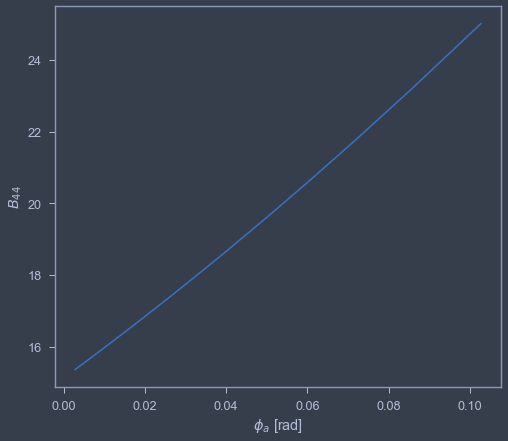

In [31]:
fig,ax=plt.subplots()
x = inputs['fi_a']
y = output['B_44']
ax.plot(x,y)
ax.set_xlabel('$\phi_a$ [rad]')
ax.set_ylabel('$B_{44}$')


In [32]:
np.array(output['B_44'])/np.array(X_amplitudes['B_n'])

array([220.15619203, 216.43961076, 213.78553395, 211.45020088,
       209.92964181, 209.14145408, 208.29162558, 207.59734788,
       207.36961231, 206.97347589, 206.39749995, 206.38231801,
       206.68514401, 206.46781746, 205.99165004, 206.03015756,
       206.28829518, 206.13001126, 205.87092656, 206.10920137,
       206.4537088 , 206.27099344, 205.86343667, 205.67919139,
       205.86164755, 206.26391714, 206.52329792,          nan])

In [33]:
equations.C_equation_linear

Eq(C, GM*g*m)

In [34]:
equations.A44

GM*g*m/omega0**2

In [35]:
mass = inputs.Volume*inputs.rho
A44_tot = lambdas.A44_lambda(GM=inputs.gm, g=inputs.g, m=mass, omega0=inputs.w)
A44_mass = mass*data.KXX**2
KXX_tot = np.sqrt(A44_tot/mass)
(KXX_tot - data.KXX)/data.KXX

0     0.174089
1     0.174089
2     0.174089
3     0.174089
4     0.174089
5     0.174089
6     0.174089
7     0.174089
8     0.174089
9     0.174089
10    0.174089
11    0.174089
12    0.174089
13    0.174089
14    0.174089
15    0.174089
16    0.174089
17    0.174089
18    0.174089
19    0.174089
20    0.174089
21    0.174089
22    0.174089
23    0.174089
24    0.174089
25    0.174089
26    0.174089
27    0.174089
dtype: float64

In [36]:
results = estimator_ikeda_quadratic.result_for_database()
results

{'zeta': 0.036588024189946715,
 'd': 0.5442643525426031,
 'omega0': 2.48814138164312,
 'score': 0.9042684962009301,
 'phi_start': -0.1381428102953512,
 'phi_stop': 0.0079412480965742,
 'omega0_fft': 2.48814138164312,
 'B_44_1': 20.039803465353693,
 'B_44_2': 26.125010601697632,
 'B_F_1': 1.1014377904648913,
 'B_F_2': 1.1014377904648913,
 'B_W_1': 4.218718560323839,
 'B_W_2': 4.218718560323839,
 'B_E_1': 0.4678599368133092,
 'B_E_2': 0.9357198736266183,
 'B_BK_1': 7.914995241710201,
 'B_BK_2': 13.532342441240832,
 'B_L_1': 6.336791936041452,
 'B_L_2': 6.336791936041452,
 'B_1': 13.954596329009753,
 'B_2': 41.71412718172688,
 'B_e': 26.125010601697632}

In [37]:
equations.extinction_equation

Eq(phi_a, phi_0(t)*exp(-omega0*t*zeta))

<AxesSubplot:>

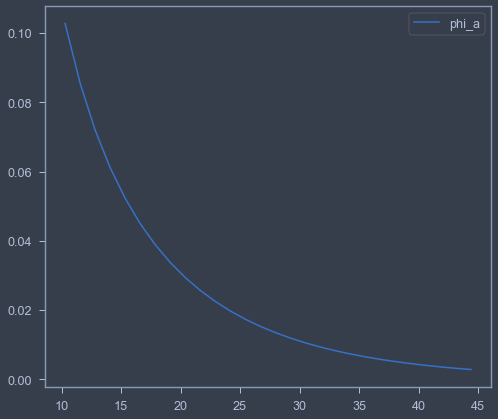

In [38]:
fig,ax=plt.subplots()
X_amplitudes.plot(y='phi_a', ax=ax)

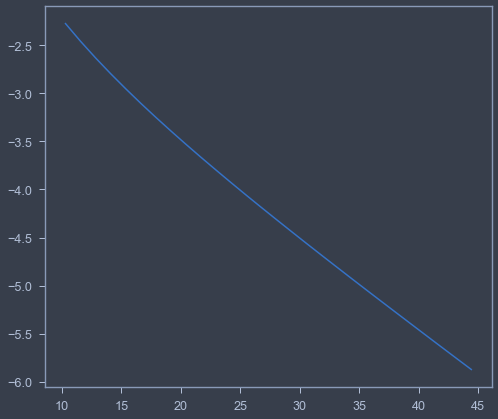

In [39]:
t = X_amplitudes.index
y = np.log(X_amplitudes['phi_a'])

fig,ax=plt.subplots()
ax.plot(t,y)

In [40]:
sp.Eq(symbols.zeta,sp.solve(equations.extinction_equation,symbols.zeta)[0])

Eq(zeta, log(phi_0(t)/phi_a)/(omega0*t))

In [41]:
zeta_lambda = lambdify(sp.solve(equations.extinction_equation,symbols.zeta)[0])
phi_0 = X_amplitudes['phi_a'].iloc[0]
t = X_amplitudes.index - X_amplitudes.index[0]
X_amplitudes['zeta2'] = zeta_lambda(omega0=X_amplitudes['omega0'],phi_0=phi_0, phi_a=X_amplitudes['phi_a'],
            t=t)

In [42]:
omega0 = inputs.iloc[0]['omega0']

for i in range(len(X_amplitudes)-1):
    
    row1 = X_amplitudes.iloc[i]
    row2 = X_amplitudes.iloc[i+1]
    t_ = row2.name - row1.name
    B_n = zeta_lambda(omega0=omega0,phi_0=row1['phi_a'], phi_a=row2['phi_a'],
            t=t_)
    
    X_amplitudes.loc[row2.name,'B_n2'] = B_n

In [43]:
X_amplitudes['B_n3'] = np.array(output['B_44']/(A44_tot))

<AxesSubplot:xlabel='phi_a'>

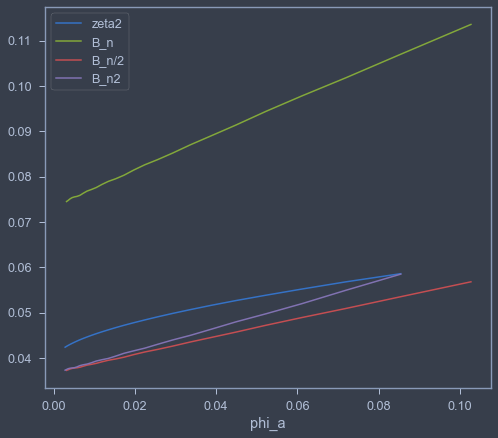

In [44]:
fig,ax=plt.subplots()
X_amplitudes.plot(x='phi_a',y='zeta2',ax=ax)
X_amplitudes.plot(x='phi_a',y='B_n', ax=ax)

X_amplitudes['B_n/2'] = X_amplitudes['B_n']/2
X_amplitudes.plot(x='phi_a',y='B_n/2', ax=ax)

X_amplitudes.plot(x='phi_a',y='B_n2', ax=ax)
#X_amplitudes.plot(x='phi_a',y='B_n3', ax=ax)